<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Linear/FOSM uncertainty is cool, but for the NEXT BIG THING, you gotta go Monte Carlo 

## (what's old is new again)

As we've seen, First-Order-Second-Moment (FOSM) is quick and insightful.  But FOSM depends on an assumption that the relation between the model and the forecast uncertainty is linear.  But many times the world is nonlinear. Short cuts like FOSM need assumptions, but we can free ourselves by taking the brute force approach.  That is define the parameters that are important, provide the prior uncertainty, sample those parameters many times, run the model many times, and then summarize the results.  

On a more practical standpoint, the underlying theory for FOSM and why it results in shortcomings can be hard to explain to stakeholders.  Monte Carlo, however, is VERY straightforward, its computational brute force notwithstanding. 

### Here's a flowchart from Anderson et al. (2015):

<img src="Fig10.14_MC_workflow.png" style="float: center">

What do we get when we do this?  Here are results from a MODFLOW-Monte Carlo model that was built to determine the capture zone for a spring (Hunt et al., 2001). They showe that we can get average heads for all the runs:

<img src="PB_avg_heads_Hunt2001.png" style="float: center">

But even cooler - we can get a map of standard deviation of those heads:

<img src="PB_stdev_heads_Hunt2001.png" style="float: center">

## Even cooler - the forecast for the area that provdes recharge to the spring can be related to stakeholders probabilistically!

<img src="FigB10.4.2_MC_probablistic_capture_zone.png" style="float: center">

### Objectives of this notebook

1) Run a real Monte Carlo run on the Freyberg model

2) Look at parameter and forecast uncertainty 

3) Start thinking of the advantages and disadvantages of linear and nonlinear uncertainty methods

# Quick reminder of what the model looks like:

It is a heterogenous 2D areal (1-layer) model that is a step up in complexity from our xsec model. Recall it looks like this:

<img src="Freyberg_k_plot_GW_Vistas.png" style="float: left">

### Standard two blocks needed to prep the notebook for what we cant to do

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_kr(make_porosity_tpl=True)
working_dir = fs.WORKING_DIR_KR
pst_name = fs.PST_NAME_KR

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/jeremyw/Dev/gw1876/activities/freyberg_k_and_r_mc/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/23  5:20:39

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Grou

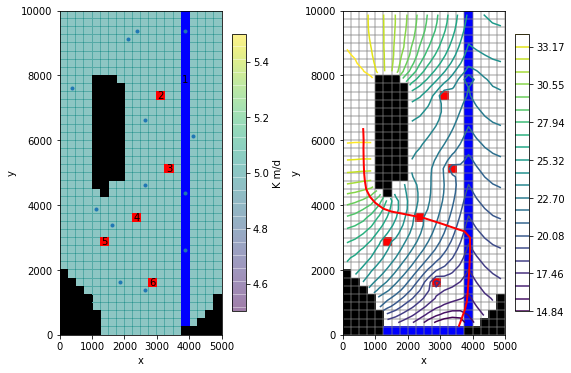

In [3]:
fs.plot_model(working_dir, pst_name)

## Let's do some Monte Carlo

Monte Carlo uses a lots and lots of forward runs so we don't want to make the mistake of burning the silicon for a PEST control file that is not right.  Here we make doubly sure that the control file has the recharge freed (not "fixed' in the PEST control file).  Note you can use this block in the future for your models....

In [4]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
obs = pst.observation_data
obs.loc[obs.obgnme=="calflux","weight"] = 0.05#super subjective
pst.write(os.path.join(working_dir,pst_name))
pst.parameter_data.index

Index(['hk', 'porosity', 'rch_0', 'rch_1'], dtype='object', name='parnme')

Ah - the recharge for the first stress period (rch_0) is fixed. But, really, by leaving the recharge for the future (rch_1) fixed we are saying that we know it perfectly when we know it even less than the the calibration period rch_0.  Being the purpose of the model is to forecast the future, in our Monte Carlo we may want to include this.  Let's use pyemu to reset both rch_0 and rch_1 (though a text editor is fine too). 

In [5]:
pst.parameter_data.loc[["rch_0","rch_1"],"partrans"] = "log"


pst.write(os.path.join(working_dir,pst_name))
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,1.00,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,log,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


## Good - past and future recharge are freed.  Now let's draw 500 tries from the parameter set.  

Look in the command below - how does it decide the range of parameters to pull from....

(this takes some time so wait for the 0 to show up below the code block before advancing)

In [6]:
prior_cov = pyemu.Cov.from_parameter_data(pst,sigma_range=6)
#mc = pyemu.MonteCarlo(pst=pst,parcov=prior_cov)
#mc.draw(num_reals=500,enforce_bounds="reset")
parensemble = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,cov=prior_cov,num_reals=500)
parensemble.enforce()

making diagonal cov draws
building mean and std dicts
numpy draw
post-processing
build df
handling fixed pars


###  Here's some parameter distributions you could use to control the values pulled from the parameter range (taken from Anderson et al. 2015).  In the code block you just ran we're using a Gaussian, or "Normal" distribution.

<img src="Fig10.13_parameter_distribution.png" style="float: left">

###  Here's an example of the first 5 parameter sets of our 500 created by our draw ("draw" here is like "drawing" a card

In [7]:
parensemble.head()

parnme,hk,porosity,rch_0,rch_1
0,1.523424,0.007947,0.997868,1.471330
1,3.267810,0.013746,0.660505,1.145431
2,1.292339,0.010228,0.960184,1.468894
3,2.423224,0.008559,1.081811,1.460859
4,3.493841,0.007562,0.868715,0.997691


Let's look at the distributions we are running

### an aside on covariance...

making full cov draws with home-grown goodness
generating snv matrix
eigen solve for full cov
form projection
handling fixed pars


Text(0,0.5,'rch_0')

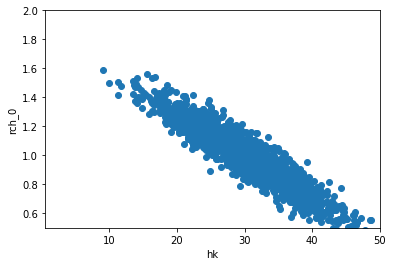

In [11]:
pst1 = pyemu.Pst(os.path.join(working_dir,pst_name))
par = pst1.parameter_data
par.loc[:,"partrans"] = 'fixed'
par.loc[["hk","rch_0"],"partrans"] = "none"
par.loc["hk","parval1"] = 30
prior_cov = pyemu.Cov.from_parameter_data(pst1,sigma_range=8)
prior_cov = pyemu.Cov(prior_cov.as_2d,names=prior_cov.row_names)
c = float(prior_cov.x[0,0] * prior_cov.x[1,1] * -0.8)
#print(c)
prior_cov.x[0,1] = c
prior_cov.x[1,0] = c
#print(prior_cov)
#mc.draw(num_reals=2000,enforce_bounds="reset")
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst1,cov=prior_cov,
                                                         use_homegrown=True,
                                                         num_reals=2000,
                                                         group_chunks=False)

ax = plt.subplot(111)
ax.scatter(pe.hk,pe.rch_0)
ax.set_xlim(par.loc["hk","parlbnd"],par.loc["hk","parubnd"])
ax.set_ylim(par.loc["rch_0","parlbnd"],par.loc["rch_0","parubnd"])
ax.set_xlabel("hk")
ax.set_ylabel("rch_0")

0.5 50.0 6.623260308913753


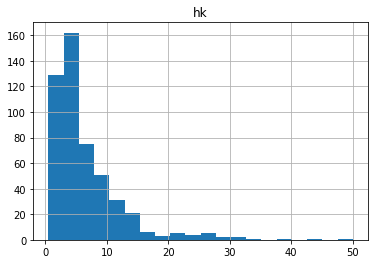

0.005012138562344867 0.01816566919806238 0.010232743960781738


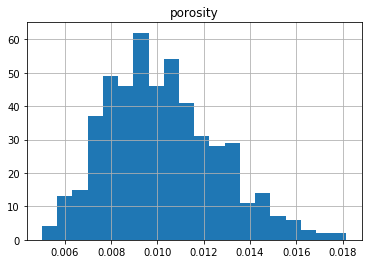

0.511896837452274 2.0 1.032840133754475


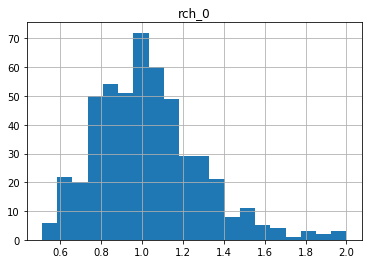

0.25 3.0 1.073549074673628


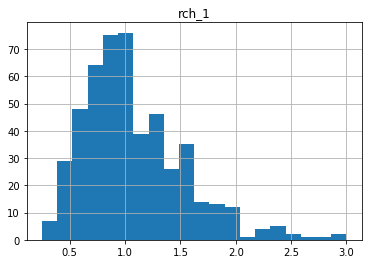

In [12]:
for pname in pst.par_names:
    ax = parensemble.loc[:,pname].hist(bins=20)
    print(parensemble.loc[:,pname].min(),parensemble.loc[:,pname].max(),parensemble.loc[:,pname].mean())
    ax.set_title(pname)
    plt.show()
    

#### Compare these distributions to the upper and lower bounds of the parameters:

In [13]:
pst.parameter_data
pst.write(os.path.join(working_dir,pst_name.replace('.pst','.por.pst')))

Do the log transformed parameters look like a log normal distribution?

## Using what you just learned, now we'll make sweep through the possible combinations and distribute them across the multicores available on your laptop (just like in the response surface notebooks)

##  We are going to run the forward model 500 times (!!!!) so it will take some time. 

using ``sweep`` - like we just talked about, watch the C= part of the YAMR progress line - this is the runs __C__ompleted. F = __F__ailed; T = __T__imed out; R = __R__unning; W = __W__aiting to run; U = __U__navailable



In [ ]:
parensemble.to_csv(os.path.join(working_dir,"sweep_in.csv"))
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"sweep",pst_name.replace('.pst','.por.pst'),num_slaves=15,master_dir='.')
os.chdir("..")

## Alright - let's see some MC results.  For these runs, what was the Phi?

In [15]:
df_out = pd.read_csv(os.path.join(working_dir,"sweep_out.csv"),index_col=0)
df_out = df_out.loc[df_out.failed_flag==0,:] #drop an failed runs
df_out.columns = [c.lower() for c in df_out.columns]
df_out.head()

FileNotFoundError: File b'freyberg_kr/sweep_out.csv' does not exist

### Wow, some are pretty large.  Let's plot Phi for all 500 runs

In [16]:
df_out.phi.hist(bins=100)


NameError: name 'df_out' is not defined

### Wow, some of those models are really REALLY bad fits to the observations.  So when we only use our prior knowledge to sample the parameters we get a bunch of models with unacceptably Phi, and we can consider them not reasonable.  Therefore, we should NOT include them in our uncertainty analysis.


# PAY ATTENTION:  this is super important - in this next block we are "conditioning" our Monte Carlo run by removing the bad runs based on a Phi cutoff. So here is the code where we are choosing which realizations we consider ``good enough`` with respect to fitting the observation data.  This is formally known as "GLUE" in the literature.

Let's say we'll say any Phi below 2000 is acceptable...

In [17]:
acceptable_phi = 2000.0
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print(good_enough)

NameError: name 'df_out' is not defined

These are the run number of the 500 that met this cutoff.  Let's plot just these "good" ones:

In [ ]:
#ax = df_out.phi.hist(alpha=0.5)
df_out.loc[good_enough,"phi"].hist(color="g",alpha=0.5)
plt.show()

# Now the payoff - using our good runs, let's make some probablistic plots!  Here's our parameters

### Gray blocks show the range of the runs we threw out.  But those were considered within our bounds when we started, so those grey boxes represent our prior

### The blue boxes show the runs that met our criteria, so that distribution represents our posterior

In [ ]:
for parnme in pst.par_names:
    ax = plt.subplot(111)
    mc.parensemble.loc[:,parnme].hist(bins=10,alpha=0.5,color="0.5",ax=ax,normed=True)
    mc.parensemble.loc[good_enough,parnme].hist(bins=10,alpha=0.5,color="b",ax=ax,normed=True)
    ax.set_title(parnme)
    plt.show()

### Similar to the FOSM results, the future recharge (``rch_1``) is not influenced by calibration - why?

## Let's look at the forecasts

In [ ]:
for forecast in pst.forecast_names:
    ax = df_out.loc[:,forecast].hist(alpha=0.5,color='0.5',normed=True)
    ax.set_yticklabels([])
    df_out.loc[good_enough,forecast].hist(ax=ax,alpha=0.5,color='b',normed=True)
    ax.set_title(forecast)
    plt.show()

We see a substaintial reduction in uncertainty (prior vs posterior) for all forecasts...great!

# What a power POWERFUL method to show our uncertainty, and what we learned from history matching.  Moreover, we are free of a lot of the limiting assumptions of FOSM.  

(What's the downside?)

Just for fun, let's see how the forecast prior and posterior uncertainty compare to the "truth" (since we know the "truth")

In [ ]:
for forecast in pst.forecast_names:
    ax = df_out.loc[:,forecast].hist(alpha=0.5,color='0.5',normed=True)
    ax.set_yticklabels([])
    df_out.loc[good_enough,forecast].hist(ax=ax,alpha=0.5,color='b',normed=True)
    ax.set_title(forecast)
    ylim = ax.get_ylim()
    v = mc.pst.observation_data.loc[forecast,"obsval"]
    ax.plot([v,v],ylim,"k--",lw=2.0)
    ax.set_title(forecast)
    
    plt.show()

### Oh-oh - some of our forecasts we are outside of our conditioned probabilities - that is, the posterior of several forecasts is overly narrow (non-conservative)...why? Our uncertainty analysis is not robust even with MC, and I thought this was just a problem with the assumptions in FOSM!